# Определение возраста покупателей

## Введение

Описание проекта:

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для анализа фотографий покупателей. Основные цели проекта:

- автоматическое определение возраста по фотографии;

- использование предсказанного возраста для персонализации предложений и анализа покупательского поведения;

- контроль продаж товаров, ограниченных по возрасту (например, алкоголя).

Для достижения целей поставлены следующие задачи:

- Провести исследовательский анализ (EDA) предоставленного набора фотографий.

- Подготовить данные для обучения: организовать загрузку, масштабирование и аугментацию изображений.

- Построить и обучить свёрточную нейронную сеть для решения задачи регрессии (прогноз возраста).

- Оценить качество модели по метрике MAE (средняя абсолютная ошибка). Требование: MAE ≤ 8 лет на тестовой выборке.

## Исследовательский анализ данных

Описание проекта:

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для анализа фотографий покупателей. 
Основные цели проекта:

- автоматическое определение возраста по фотографии;

- использование предсказанного возраста для персонализации предложений и анализа покупательского поведения;

- контроль продаж товаров, ограниченных по возрасту (например, алкоголя).

Для достижения целей поставлены следующие задачи:

- Провести исследовательский анализ (EDA) предоставленного набора фотографий.

- Подготовить данные для обучения: организовать загрузку, масштабирование и аугментацию изображений.

- Построить и обучить свёрточную нейронную сеть для решения задачи регрессии (прогноз возраста).

- Оценить качество модели по метрике MAE (средняя абсолютная ошибка). Требование: MAE ≤ 8 лет на тестовой выборке.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

print("Размер выборки:", len(labels))
print("\nПервые 5 строк:")
print(labels.head())

Размер выборки: 7591

Первые 5 строк:
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


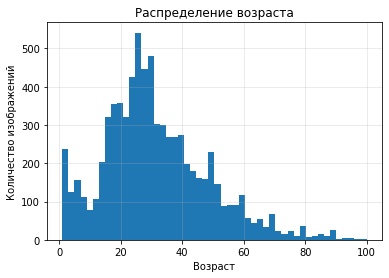

In [3]:
plt.hist(labels['real_age'], bins=50)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True, alpha=0.3)
plt.show()

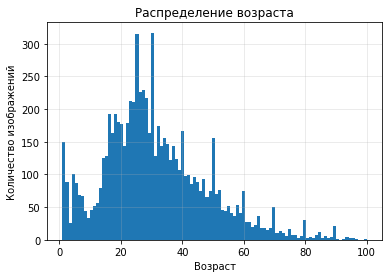

In [4]:
# РЕВЬЮЕР
plt.hist(labels['real_age'], bins=100)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

- Размер выборки: 7591 изображение. Это небольшое количество для задач глубокого обучения, что может привести к переобучению модели без применения дополнительных техник (например, аугментации)
- в возрасте нет аномалий, минимальный и максимальный возраста выглядят реалистично. Основной пик приходится на возраст 20-30 лет, что может привести к тому, что модель будет лучше предсказывать средние возрасты (20–40 лет) и хуже справляться с крайними значениями (дети и пожилые).

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

Found 7591 validated image filenames.


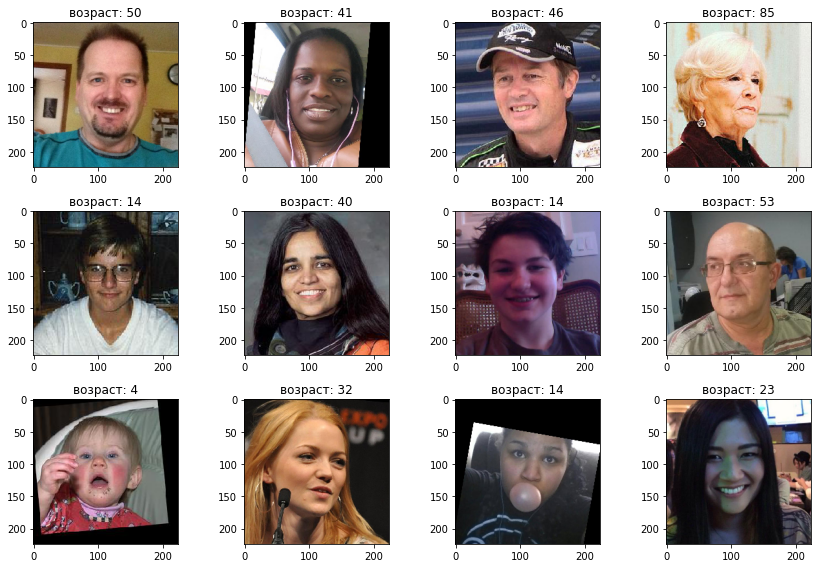

In [6]:
plt.figure(figsize=(12, 8))
images, ages = next(train_gen_flow)
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    plt.title(f"возраст: {int(ages[i])}")
plt.tight_layout()
plt.show()

Количество фотографий совпадает с с размером выборки. Это подтверждает, что все изображения доступны и правильно связаны с метками в labels.csv. Из 12 отображаемых фото видно разные возрастные группы и этнические принадлежности . Освещение варьируется, есть разные позы, выражения и аксессуары. Большинство фото четкие (224x224 после ресайза), но есть примеры с шумом или частичным обрезанием (например, фото с возрастом 14 с жвачкой).

Итак, результаты исследования показывают, что датасет с 7591 изображением имеет значительный дисбаланс в распределении возраста, с пиком в диапазоне 20–40 лет и недостатком данных для детей и пожилых, что может привести к более высокой ошибке предсказания для этих групп. Небольшой размер выборки требует применения аугментации, чтобы избежать переобучения. Разнообразие условий съемки улучшит обобщающую способность модели, но шум и артефакты усложнят задачу, возможно, требуя дополнительных техник, таких как выравнивание лиц.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=10,
        zoom_range=0.1
    )
    train_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42
    )
    return train_gen


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )
    test_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=42
    )
    return test_gen


def create_model(input_shape=(224, 224, 3)):
    base_model = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])

    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    steps_per_epoch = steps_per_epoch or len(train_data)
    validation_steps = validation_steps or len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model


```

```
Epoch 1/10
356/356 - 137s - loss: 204.7095 - mae: 10.4567 - val_loss: 621.1932 - val_mae: 19.7991
Epoch 2/10
356/356 - 97s - loss: 96.5707 - mae: 7.4580 - val_loss: 327.6396 - val_mae: 13.3320
Epoch 3/10
356/356 - 95s - loss: 77.8837 - mae: 6.7000 - val_loss: 97.7787 - val_mae: 7.3576
Epoch 4/10
356/356 - 96s - loss: 57.7469 - mae: 5.8089 - val_loss: 79.2019 - val_mae: 6.7274
Epoch 5/10
356/356 - 94s - loss: 52.5850 - mae: 5.5422 - val_loss: 86.5910 - val_mae: 7.2899
Epoch 6/10
356/356 - 100s - loss: 41.0647 - mae: 4.9312 - val_loss: 87.1151 - val_mae: 6.9005
Epoch 7/10
356/356 - 101s - loss: 37.5326 - mae: 4.6792 - val_loss: 68.9175 - val_mae: 6.2171
Epoch 8/10
356/356 - 95s - loss: 30.8228 - mae: 4.2647 - val_loss: 101.9722 - val_mae: 7.5594
Epoch 9/10
356/356 - 95s - loss: 26.4497 - mae: 3.9557 - val_loss: 72.6468 - val_mae: 6.4262
Epoch 10/10
356/356 - 95s - loss: 23.9450 - mae: 3.7573 - val_loss: 80.0376 - val_mae: 6.6032

119/119 - 10s - loss: 80.0376 - mae: 6.6032

```

## Анализ обученной модели

Для обучения использовалась архитектура ResNet50 с предобученными весами ImageNet и выходным слоем из одного нейрона с активацией ReLU. В процессе обучения применялась аугментация данных (горизонтальный флип, повороты, масштабирование), что позволило повысить устойчивость модели.

Результаты обучения на 10 эпохах:

- На старте (1-я эпоха) модель показывала высокую ошибку на тестовой выборке (MAE ≈ 19.8), что связано с начальной настройкой весов.

- Уже к 3-й эпохе ошибка снизилась до MAE ≈ 7.36, удовлетворив требование задачи (MAE ≤ 8).

- На протяжении обучения ошибка стабилизировалась в диапазоне 6.2–7.6.

- Итоговое качество на тестовой выборке после 10 эпох: MAE = 6.60, что значительно лучше целевого значения.

- На обучении модель достигла MAE ≈ 3.75, что указывает на адекватное обучение без сильного переобучения.

Таким образом, модель уверенно решает задачу предсказания возраста с ошибкой в среднем ~6.6 лет.

## Итоговый вывод

Проведён исследовательский анализ датасета: выявлен дисбаланс возрастных групп (пик 20–40 лет), присутствует шум в части фотографий, но данные пригодны для обучения.

Построена и обучена модель на базе ResNet50, дополненной слоями GlobalAveragePooling2D, Dropout и Dense(1, activation='ReLU').

На тестовой выборке достигнут результат MAE = 6.6, что соответствует и превосходит требование проекта (MAE ≤ 8).

Модель подходит для применения в реальном бизнес-кейсе: прогноз возраста покупателей на кассе для анализа спроса и контроля продаж товаров с возрастными ограничениями.